In [2]:
# Install dependencies
#%pip install datasets
#%pip install transformers
#%pip install spacy
#%pip install torch
#%pip install spacy-transformers
#%pip install transformers[torch]
#%pip install seqeval
#%pip install pandas
#%pip install matplotlib
#%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [1]:
# load dataset and get the dataset splits
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]  
# Take labels from strings to class indexes for use in data analysis
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 2}

train_label_list = []
for sample in train_dataset["ner_tags"]:
    train_label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in val_dataset["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in test_dataset["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])


from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer2 = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model2 = AutoModelForTokenClassification.from_pretrained("sentence-transformers/all-mpnet-base-v2", num_labels=3)

#tokenizer2 = AutoTokenizer.from_pretrained("all-mpnet-base-v2-finetuned-NER", local_files_only=True)
#model2 = AutoModelForTokenClassification.from_pretrained("all-mpnet-base-v2-finetuned-NER", num_labels=3, local_files_only=True)


#                          
tokenized_input = tokenizer2(train_dataset["tokens"], is_split_into_words=True)
def tokenize_and_align_labels(train_dataset, list_name):
    tokenized_inputs = tokenizer2(train_dataset["tokens"], truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_train_datasets = tokenize_and_align_labels(train_dataset, train_label_list)
tokenized_val_datasets = tokenize_and_align_labels(val_dataset, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_dataset, test_label_list)

def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

tokenised_train = turn_dict_to_list_of_dict(tokenized_train_datasets)
tokenised_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenised_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer2)

import numpy as np

metric = load_metric("seqeval",trust_remote_code=True)
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [train_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [train_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments
model_name = "sentence-transformers/all-mpnet-base-v2"
#model_name = "thenlper/gte-base"
epochs = 12
batch_size = 4
learning_rate = 6e-5

args = TrainingArguments(
    f"all-mpnet-base-v2-finetuned-NER",
    #f"thenlper/gte-base-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model2,
    args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    data_collator = data_collator,
    tokenizer=tokenizer2,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)



c:\Users\James\Desktop\Files\Education\Surrey\NLP\group-enviroment\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
C:\Users\James\AppData\Local\Temp\ipykernel_26188\536986443.py:83: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval",trust_remote_code=True)
c:\Users\James\Desktop\Files\Education\Surrey\NLP\group-enviroment\.conda\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecat

In [2]:
trainer.train()

 16%|█▌        | 502/3216 [00:31<02:40, 16.93it/s]

{'loss': 0.0452, 'learning_rate': 5.067164179104478e-05, 'epoch': 1.87}


 31%|███       | 1003/3216 [01:01<02:21, 15.64it/s]

{'loss': 0.0285, 'learning_rate': 4.1343283582089554e-05, 'epoch': 3.73}


 47%|████▋     | 1502/3216 [01:32<01:40, 16.98it/s]

{'loss': 0.0186, 'learning_rate': 3.201492537313433e-05, 'epoch': 5.6}


 62%|██████▏   | 2003/3216 [02:02<01:21, 14.81it/s]

{'loss': 0.0111, 'learning_rate': 2.2686567164179106e-05, 'epoch': 7.46}


 78%|███████▊  | 2503/3216 [02:33<00:42, 16.60it/s]

{'loss': 0.0059, 'learning_rate': 1.3358208955223882e-05, 'epoch': 9.33}


 93%|█████████▎| 3003/3216 [03:04<00:13, 16.09it/s]

{'loss': 0.0016, 'learning_rate': 4.029850746268657e-06, 'epoch': 11.19}


100%|██████████| 3216/3216 [03:17<00:00, 16.29it/s]

{'train_runtime': 197.418, 'train_samples_per_second': 65.161, 'train_steps_per_second': 16.29, 'train_loss': 0.017348682433737453, 'epoch': 12.0}


TrainOutput(global_step=3216, training_loss=0.017348682433737453, metrics={'train_runtime': 197.418, 'train_samples_per_second': 65.161, 'train_steps_per_second': 16.29, 'train_loss': 0.017348682433737453, 'epoch': 12.0})

In [3]:
# Prepare the test data for evaluation in the same format as the training data

predictions, labels, _ = trainer.predict(tokenised_test)
predictions = np.argmax(predictions, axis=2)

# Remove the predictions for the [CLS] and [SEP] tokens 
true_predictions = [
    [test_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [test_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# Compute multiple metrics on the test results
results = metric.compute(predictions=true_predictions, references=true_labels)
results

 79%|███████▉  | 31/39 [00:00<00:00, 89.63it/s]c:\Users\James\Desktop\Files\Education\Surrey\NLP\group-enviroment\.conda\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\James\Desktop\Files\Education\Surrey\NLP\group-enviroment\.conda\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: [0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\James\Desktop\Files\Education\Surrey\NLP\group-enviroment\.conda\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0] seems not to be NE tag.
  warnings.warn('{} seems 

{'0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]': {'precision': 0.75,
  'recall': 0.8089887640449438,
  'f1': 0.7783783783783783,
  'number': 267},
 '0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]': {'precision': 0.7378048780487805,
  'recall': 0.8013245033112583,
  'f1': 0.7682539682539684,
  'number': 151},
 '0, 0, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0]': {'precision': 0.7102473498233216,
  'recall': 0.75,
  'f1': 0.7295825771324863,
  'number': 536},
 'overall_precision': 0.7259332023575639,
 'overall_recall': 0.7746331236897275,
 'overall_f1': 0.7494929006085191,
 'overall_accuracy': 0.9400090211998195}

In [4]:

print(predictions[0])
print(labels[0])
true_labels = []
true_predictions = []
true_labels_sep = []
true_predictions_sep = []
for i in range(len(labels)):
  templist = []#range(sum(labels[0] != -100))
  templist2 = []
  for j in range(len(labels[i])):
    if labels[i][j]!= -100:
      true_labels.append(labels[i][j])
      true_predictions.append(predictions[i][j])
      templist.append(labels[i][j])
      templist2.append(predictions[i][j])
  true_labels_sep.append(templist)
  true_predictions_sep.append(templist2)




[0 0 0 0 1 0 2 2 2 2 2 2 2 0 1 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-100    0    0    0    1    0    2    2    2    2    2    2    2    0
    1    0    2    2    2    2    2    0 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100]


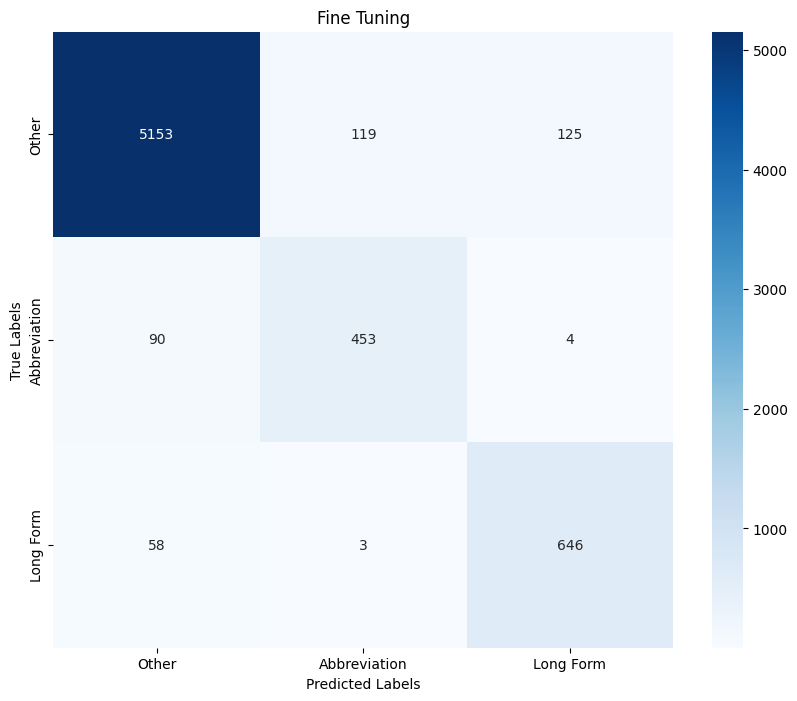

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(true_labels, true_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=["Other", "Abbreviation","Long Form"], yticklabels=["Other", "Abbreviation","Long Form"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Fine Tuning')
plt.show()
plt.savefig('confusionmatrix.png')

In [8]:
print(tokenized_test_datasets[0])
#print(tokenised_test[0])
print(test_dataset[0])
print(test_label_list[0])
print(true_labels_sep[0])


#print(tokenized_test_datasets)
# Example single sentence example.
for token in tokenized_test_datasets["input_ids"]:
    print(token)
    print(tokenizer2.convert_ids_to_tokens(token))
    print(tokenizer2.convert_tokens_to_string(tokenizer2.convert_ids_to_tokens(token)))
    break

Encoding(num_tokens=23, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
{'tokens': ['Abbreviations', ':', 'GEMS', ',', 'Global', 'Enteric', 'Multicenter', 'Study', ';', 'VIP', ',', 'ventilated', 'improved', 'pit', '.'], 'pos_tags': ['NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'VERB', 'ADJ', 'NOUN', 'PUNCT'], 'ner_tags': ['B-O', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'B-O']}
[0, 0, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0]
[0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0]
[0, 22502, 2019, 1028, 20300, 1014, 3799, 4611, 2598, 4804, 13017, 2125, 2821, 1029, 21726, 1014, 18838, 11737, 3068, 5305, 6774, 1016, 2]
['<s>', 'abbreviation', '##s', ':', 'gems', ',', 'global', 'enter', '##ic', 'multi', '##cent', '##er', 'study', ';', 'vip', ',', 'vent', '##ila', '##ted', 'improved', 'pit', '.', '</s>']
<s> abbreviations : gems,

In [24]:
trainer.save_model()